In [2]:
# import libraries 
import pandas as pd 
import numpy as np 
import re 
import multiprocessing
from unidecode import unidecode
import os 
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation,Embedding, Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns


# clean unwanted thing from dataset 

In [3]:
data=pd.read_csv('train1.csv')
display(data)

,ID,Sentence1,Sentence2,Class
0,0,"But instead of returning to heaven , Annie dec...","But instead of returning to Heaven , Chris cho...",0
1,1,"In 2016 , Bacardi announced new branding and p...","In 2016 , Bacardi announced new branding and p...",0
2,2,Kweku Baako Jnr had four children . One of the...,"Baako had four children , one of whom was Kwek...",0
3,3,"As with the Navy , the Army has a single-track...","Like the army , the Navy has a single-track sy...",0
4,4,Sissi units have fewer crew served weapons and...,Sissi units have more weapons served by the cr...,0
...,...,...,...,...
15995,15995,"On July 21st , 1919 , the army was renamed int...","On July 21 , 1919 , the army was renamed the C...",1
15996,15996,"In 2012 , the championships were held in Dunak...","In 2012 , the championships were held in Italy...",0
15997,15997,"At least 3 inserts were printed , but none of ...","At least 3 supplements were printed , but none...",1
15998,15998,The builders of Waimate North were also Willia...,The builders of St. James were also William Wi...,0


<Axes: xlabel='Class', ylabel='count'>

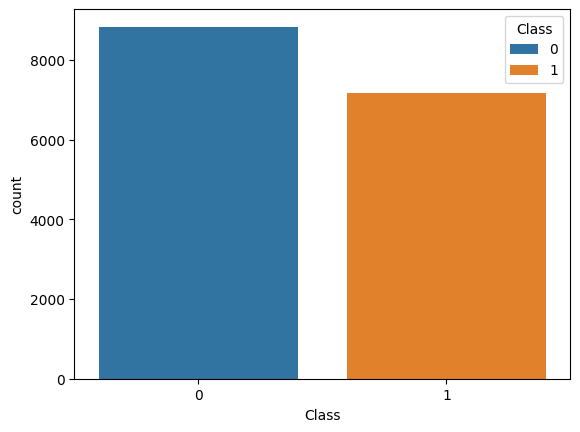

In [4]:
sns.countplot(x='Class', data=data,hue='Class')

In [5]:
data.shape

(16000, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         16000 non-null  int64 
 1   Sentence1  16000 non-null  object
 2   Sentence2  16000 non-null  object
 3   Class      16000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 500.1+ KB


In [7]:
data.isnull().sum()

ID           0
Sentence1    0
Sentence2    0
Class        0
dtype: int64

# Data Cleaning 

In [8]:
# Remove punctuation 
import string
from string import punctuation
def remove_punctuation(text):
    no_punctuation=[words for words in text if words not in punctuation ]
    words_wo_punct=''.join(no_punctuation)
    return words_wo_punct
data["Sentence1"]=data["Sentence1"].apply(lambda x:remove_punctuation(x))
data["Sentence2"]=data["Sentence2"].apply(lambda x:remove_punctuation(x))
data.head()

,ID,Sentence1,Sentence2,Class
0,0,But instead of returning to heaven Annie deci...,But instead of returning to Heaven Chris choo...,0
1,1,In 2016 Bacardi announced new branding and pl...,In 2016 Bacardi announced new branding and pl...,0
2,2,Kweku Baako Jnr had four children One of them...,Baako had four children one of whom was Kweku...,0
3,3,As with the Navy the Army has a singletrack s...,Like the army the Navy has a singletrack syst...,0
4,4,Sissi units have fewer crew served weapons and...,Sissi units have more weapons served by the cr...,0


In [9]:
# Remove stopwords 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stop_words=set(stopwords.words('english'))
stemmer=SnowballStemmer('english')

data['Sentence1'] = data['Sentence1'].apply(lambda x: ' '.join([stemmer.stem(word.lower()) for word in x.split() if word.lower() not in stop_words]))
data['Sentence2'] = data['Sentence2'].apply(lambda x: ' '.join([stemmer.stem(word.lower()) for word in x.split() if word.lower() not in stop_words]))
data.head()     

,ID,Sentence1,Sentence2,Class
0,0,instead return heaven anni decid join chris he...,instead return heaven chris choos join anni fo...,0
1,1,2016 bacardi announc new brand plan sell versi...,2016 bacardi announc new brand plan sell versi...,0
2,2,kweku baako jnr four children one baako journa...,baako four children one kweku baako jnr journa...,0
3,3,navi armi singletrack system offic navi commun...,like armi navi singletrack system offic navi c...,0
4,4,sissi unit fewer crew serv weapon sniper rifl ...,sissi unit weapon serv crew fewer sniper rifl ...,0


In [10]:
""" # Tokenization 
from nltk.tokenize import word_tokenize
data['Sentence1']=data['Sentence1'].apply(lambda x:' '.join(word_tokenize(x)))
data['Sentence2']=data['Sentence2'].apply(lambda x:' '.join(word_tokenize(x)))
data.head() """

" # Tokenization \nfrom nltk.tokenize import word_tokenize\ndata['Sentence1']=data['Sentence1'].apply(lambda x:' '.join(word_tokenize(x)))\ndata['Sentence2']=data['Sentence2'].apply(lambda x:' '.join(word_tokenize(x)))\ndata.head() "

# Using Sequential model 

 

In [11]:
# split the dataset into train and test
train_size=int(len(data)*0.8)
train_data=data[:train_size]
test_data=data[train_size:]

In [12]:
#Tokenize the text data 
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['Sentence1'])

X_train=tokenizer.texts_to_sequences(train_data['Sentence1'])
X_train=pad_sequences(X_train,maxlen=100)


X_test=tokenizer.texts_to_sequences(test_data['Sentence1'])
X_test=pad_sequences(X_test,maxlen=100)



In [13]:
# Define the LSTM model architecture 

# Model creation 
with tf.device('/gpu:0'):
    
    model = Sequential()
    model.add(Embedding(5000, 128, input_length=100))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.fit(X_train, train_data['Class'], batch_size=64,epochs=10,validation_data=(X_test, test_data['Class']))
    
   

Epoch 1/10
200/200 [==============================] - 17s 38ms/step - loss: 0.6885 - accuracy: 0.5520 - val_loss: 0.6839 - val_accuracy: 0.5703
Epoch 2/10
200/200 [==============================] - 6s 32ms/step - loss: 0.6471 - accuracy: 0.6220 - val_loss: 0.7063 - val_accuracy: 0.5394
Epoch 3/10
200/200 [==============================] - 6s 30ms/step - loss: 0.6255 - accuracy: 0.6605 - val_loss: 0.7350 - val_accuracy: 0.5362
Epoch 4/10
200/200 [==============================] - 6s 29ms/step - loss: 0.5629 - accuracy: 0.7049 - val_loss: 0.7767 - val_accuracy: 0.5337
Epoch 5/10
200/200 [==============================] - 6s 29ms/step - loss: 0.5153 - accuracy: 0.7390 - val_loss: 0.8479 - val_accuracy: 0.5191
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.4706 - accuracy: 0.7694 - val_loss: 0.9030 - val_accuracy: 0.5269
Epoch 7/10
200/200 [==============================] - 6s 30ms/step - loss: 0.4302 - accuracy: 0.7857 - val_loss: 0.9886 - val_accuracy: 0.521

In [14]:
loss, accuracy = model.evaluate(X_test, test_data['Class'])

100/100 [==============================] - 2s 13ms/step - loss: 1.3345 - accuracy: 0.5163


In [15]:
# when no plaraphrase detection  
new_text = ["How do I file for bankruptcy?", "Can you file for bankruptcy twice?"]
new_text = tokenizer.texts_to_sequences(new_text)
new_text = pad_sequences(new_text, maxlen=100)
prediction = model.predict(new_text)
print(prediction)

1/1 [==============================] - 1s 941ms/step
[[0.06604327]
 [0.3883143 ]]


# Logistic Regression

In [16]:
# split the data into traing and test data 
train_data,test_data,train_labels,test_labels=train_test_split(data['Sentence1'].astype(str)+' '+data['Sentence2'].astype(str),data['Class'],
                                                               test_size=0.2,
                                                               random_state=42)

In [17]:
# vectorize the text data 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

In [18]:
# Train Logistric Regression model 
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(train_vectors, train_labels)

LogisticRegression(max_iter=1000)

In [19]:
pred_lebales=model.predict(test_vectors)

In [20]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(pred_lebales,test_labels)
print('Model Accuracy',accuracy) 

Model Accuracy 0.5221875


# Naive Bayes Model 

In [21]:
# Train Naive Bayes Classifier 
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()
clf.fit(train_vectors,train_labels)

MultinomialNB()

In [22]:
y_pred=clf.predict(test_vectors)

In [23]:
# calculate the accuracy of the classifier 
accuracy=accuracy_score(y_pred,test_labels)
print("Accuracy:",accuracy)

Accuracy: 0.5078125


# SVM 

In [24]:
data_new=pd.read_csv('train1.csv')
data_new.head()

,ID,Sentence1,Sentence2,Class
0,0,"But instead of returning to heaven , Annie dec...","But instead of returning to Heaven , Chris cho...",0
1,1,"In 2016 , Bacardi announced new branding and p...","In 2016 , Bacardi announced new branding and p...",0
2,2,Kweku Baako Jnr had four children . One of the...,"Baako had four children , one of whom was Kwek...",0
3,3,"As with the Navy , the Army has a single-track...","Like the army , the Navy has a single-track sy...",0
4,4,Sissi units have fewer crew served weapons and...,Sissi units have more weapons served by the cr...,0


In [25]:
train1, test1= train_test_split(data_new,random_state=42,test_size=0.2)
training_sentences=[]
testing_sentences=[]



train_sentences=train1['Sentence1'].values
train_labels=train1['Class'].values

for i in range(train_sentences.shape[0]):
    x=str(train_sentences[i])
    training_sentences.append(x)
training_sentences=np.array(training_sentences)



test_sentences=test1['Sentence1'].values
test_labels=test1['Class'].values

for i in range(test_sentences.shape[0]):
    x=str(test_sentences[i])
    testing_sentences.append(x)

testing_sentences=np.array(testing_sentences)

train_labels=tf.keras.utils.to_categorical(train_labels)

test_labels=tf.keras.utils.to_categorical(test_labels)

print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 12800
Testing Set Length: 3200
training_sentences shape: (12800,)
testing_sentences shape: (3200,)
train_labels shape: (12800, 2)
test_labels shape: (3200, 2)


In [26]:
from spacy.lang.de.stop_words import STOP_WORDS
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer


def tokenize(text):
    tknzr=TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return(stemmer.stem(w) for w in analyzer(doc))

en_stopwords=list(STOP_WORDS)

vectorizer=CountVectorizer(analyzer='word',
                           tokenizer=tokenize,
                           lowercase=True,
                           ngram_range=(1,1),stop_words=en_stopwords)

In [27]:
from sklearn.model_selection import StratifiedKFold
kflod=StratifiedKFold(n_splits=5, shuffle=True,random_state=1)

In [28]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [29]:
np.random.seed(1)
Pipeline_svm=make_pipeline(vectorizer,SVC(probability=True,kernel='linear',class_weight='balanced'))
grid_svm=GridSearchCV(Pipeline_svm,
                      param_grid={'svc__C':[0.01, 0.1,1]},
                      cv=kflod,
                      scoring='roc_auc',
                      verbose=1,
                      n_jobs=-1)
train_labels_new=train1['Class'].values

In [30]:
grid_svm.fit(train_sentences,train_labels_new)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\user\anaconda3\envs\env_python3.9\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words=['kam',
                                                                    'darüber',
                                                                    'ende',
                                                                    'waren',
                                                                    'sollten',
                                                                    'welche',
                                                                    'mancher',
                                                                    'sechstes',
                                                                    'derjenigen',
                                                                    'man',
                                                                    'mochte',
                                                                    'sechsten',
                                                                    'zweites',
                                                                    'weiteres',
                                                                    'ausser',
                                                                    'viele',
                                                                    'einiger',
                                                                    'neunter',
                                                                    'genug',
                                                                    'eine',
                                                                    'früher',
                                                                    'eigene',
                                                                    'demselben',
                                                                    'ihrer',
                                                                    'gute',
                                                                    'wollte',
                                                                    'dritter',
                                                                    'nun',
                                                                    'zehn',
                                                                    'durfte', ...],
                                                        tokenizer=<function tokenize at 0x00000149481174C0>)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            kernel='linear',
                                            probability=True))]),
             n_jobs=-1, param_grid={'svc__C': [0.01, 0.1, 1]},
             scoring='roc_auc', verbose=1)

In [31]:
X_test=test1['Sentence1'].values
y_test=test1['Class'].values
grid_svm.score(X_test,y_test)

0.5428456665153005

In [32]:
grid_svm.best_params_

{'svc__C': 0.01}

In [33]:
grid_svm.best_score_

0.5554024854213496

In [34]:
from sklearn.metrics import make_scorer, accuracy_score,f1_score,roc_curve,auc,roc_auc_score,recall_score,precision_score

In [35]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [36]:
report_results(grid_svm.best_estimator_, X_test, y_test)


{'auc': 0.5429075531673352,
 'f1': 0.49085467243099434,
 'acc': 0.5215625,
 'precision': 0.4733803720333547,
 'recall': 0.5096685082872928}

In [41]:
# Applying Xgboost 
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 220.2 kB/s eta 0:07:33
   ---------------------------------------- 0.0/99.8 MB 219.4 kB/s eta 0:07:35
   ---------------------------------------- 0.1/99.8 MB 403.5 kB/s eta 0:04:07
   ---------------------------------------- 0.2/99.8 MB 737.3 kB/s eta 0:02:16
   ---------------------------------------- 0.3/99.8 MB 951.8 kB/s eta 0:01:45
   ---------------------------------------- 0.4/99.8 MB 1.2 MB/s eta 0:01:26
   ---------------------------------------- 0.6/99.8 MB 1.6 MB/s eta 0:01:04
   ---------------------------------------- 1.0/99.8 MB 2.1 MB/s eta 0:00:47
   ---------------------------------------- 1.2/99.8 MB 2.5 MB/s eta 0:00:40
   --------------

In [42]:
import xgboost as xgb

In [43]:
def display_scores(scores):
    print("Scores: {0}\nMean:{1:.3f}\nstd:{2:.3f}".format(scores,np.mean(scores),np.std(scores)))

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")